In [1]:
from dotenv import load_dotenv
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import StateGraph
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import ToolNode
from tool import WeatherTool, WeatherForecastTool, HotelTool, CurrencyConverterTool
from IPython.display import display, Image
from langchain_openai import ChatOpenAI
from typing import List, Optional, TypedDict, Annotated, Any
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from docx import Document


load_dotenv()

True

In [2]:
model = ChatOpenAI(model='o3-mini')

In [3]:
class TravelState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    metadata: dict[str, Any]
    search_result: Optional[str] = None
    weather_result: Optional[str] = None
    forecast_result: Optional[str] = None
    hotel_result: Optional[str] = None
    cost_result: Optional[str] = None
    currency_result: Optional[str] = None
    itinerary_result: Optional[str] = None
    summary_result: Optional[str] = None
    

In [4]:
search_tool = DuckDuckGoSearchRun()
search_model = model.bind_tools([search_tool])

def search(state: TravelState) -> TravelState:
    metadata = state['metadata']
    
    system_prompt = f'''
    Your task is to search for city attractions, tourists spots, and restaurants for the given city name in the user query. Do not search for anything else. Keep the result concise, in under five sentences.
    Use the city name as {metadata['city']}
    '''
    prompt = [system_prompt] + state['messages']
    response = search_model.invoke(prompt)
    state['search_result'] = response
    state['messages'] = [response]
    return state
    

In [5]:
weather_tool = WeatherTool()
weather_model = model.bind_tools([weather_tool])

def weather(state: TravelState) -> TravelState:
    metadata = state['metadata']
    system_prompt = f'''
    You are tasked to find the current temperature and weather condition of the city: {metadata['city']}. Use the city name as is, do not add any other information to it. Do not return anything else. Use the weather tool whenever necessary to get the latest information.
    '''
    prompt = [system_prompt] + state['messages']
    response = weather_model.invoke(prompt)
    state['weather_result'] = response
    state['messages'] = [response]
    return state

In [6]:
weather_forecast_tool = WeatherForecastTool()
weather_forecast_model = model.bind_tools([weather_forecast_tool])

def forecast(state: TravelState) -> TravelState:
    metadata = state['metadata']
    prompt = f'You are an expert in finding out the weather forecast for a given city: {metadata['city']}, using the available weather forecast tool. Provide the weather forecast only for the given city. Do not include any other information. If the number of days for which the forecast is required is not explicitly provided, consider it as 1.'
    prompt = [prompt] + state['messages']
    response = weather_forecast_model.invoke(prompt)
    state['forecast_result'] = response
    state['messages'] = [response]
    return state

In [7]:
hotel_tool = HotelTool()
hotel_model = model.bind_tools([hotel_tool])

def hotel(state: TravelState) -> TravelState:
    metadata = state['metadata']
    prompt = f'You are an expert in finding hotels for a travel experience, using the provided tools. Suggest hotels in {metadata['city']}, from {metadata['check_in']} to {metadata['check_out']}, number of adults {metadata['adults']}, currency {metadata['currency']}, and budget {metadata['budget']} and provide a list of hotels that are available for the user. Do not return any information other than the available hotels along with their prices.'
    prompt = [prompt] + state['messages']
    response = hotel_model.invoke(prompt)
    state['hotel_result'] = response
    state['messages'] = [response]
    return state

In [8]:
currency_tool = CurrencyConverterTool()
currency_model = model.bind_tools([currency_tool])

def currency(state: TravelState) -> TravelState:
    query = []
    for key, value in state.items():
        if key not in ['messages', 'metadata'] and value and value.content:
            query.append(value.content)
    metadata = state['metadata']
    system_prompt = f'You are tasked to convert the amount from the base currency to the {metadata['currency']} if those are different. Use the provided cost of the hotels, any other tourist spots costs which are included. Use the appropriate tool to get the current currency conversion rate. Do not return any other information.'
    prompt = system_prompt + '.' + '.'.join(query)
    response = currency_model.invoke(prompt)
    state['currency_result'] = response
    state['messages'] = [response]
    return state

In [9]:
def cost_calculator(state: TravelState) -> TravelState:
    query = []
    for key, value in state.items():
        if key not in ['messages', 'metadata'] and value and value.content:
            query.append(value.content)
    metadata = state['metadata']
    system_prompt = f'You are an expert in calculating the sum for a trip, keeping in mind the hotel costs, resaurant bills, and tourist attractions. If there are multiple hotel costs, create multiple results with each individual hotel cost added to the cost of city attractions, tourist spots, and restaurants. Calculate the total bill in {metadata['currency']}, for the provided information'
    prompt = system_prompt + '.' + '.'.join(query)
    response = model.invoke(prompt)
    state['cost_result'] = response
    state['messages'] = [response]
    return state

In [10]:
def itinerary(state: TravelState) -> TravelState:
    query = []
    for key, value in state.items():
        if key not in ['messages', 'metadata'] and value and value.content:
            query.append(value.content)
    metadata = state['metadata']
    system_prompt = f'You are an expert in creating travel itenaries. Use the provided information to create an itinerary and use the tool to add any important or famous tourist attraction that is missed in the provided information. Only create for the city: {metadata['city']} for dates: {metadata['check_in']} to {metadata['check_out']}. Use only the prompt to create a detailed itinerary, do not add any other information that is not the prompt.'
    prompt = system_prompt + '.'.join(query)
    response = search_model.invoke(prompt)
    state['itinerary_result'] = response
    state['messages'] = [response]
    return state

In [11]:
def summarize(state: TravelState) -> TravelState:
    query = []
    for key, value in state.items():
        if key not in ['messages', 'metadata'] and value and value.content:
            query.append(value.content)
    system_prompt = 'You are an expert in summarizing large amount of texts. Only keep the relavant information but do cover all the data points in the prompt, do not skip any. Do not include any additional information.'
    prompt = system_prompt + '.'.join(query)
    response = model.invoke(prompt)
    state['summary_result'] = response
    state['messages'] = [response]
    return state

In [12]:
search_tool_node = ToolNode([search_tool])
weather_tool_node = ToolNode([weather_tool])
forecast_tool_node = ToolNode([weather_forecast_tool])
hotel_tool_node = ToolNode([hotel_tool])
currency_tool_node = ToolNode([currency_tool])
itinerary_search_tool_node = ToolNode([search_tool])

In [13]:
def search_router(state: TravelState):
    ai_message = state['messages'][-1]
    if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
        return 'search_tool'
    return 'weather'


def weather_router(state: TravelState):
    ai_message = state['messages'][-1]
    if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
        return 'weather_tool'
    return 'forecast'


def forecast_router(state: TravelState):
    ai_message = state['messages'][-1]
    if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
        return 'forecast_tool'
    return 'hotel'


def hotel_router(state: TravelState):
    ai_message = state['messages'][-1]
    if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
        return 'hotel_tool'
    return 'currency'


def currency_router(state: TravelState):
    ai_message = state['messages'][-1]
    if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
        return 'currency_tool'
    return 'cost_calculator'


def itinerary_router(state: TravelState):
    ai_message = state['messages'][-1]
    if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
        return 'itinerary_tool'
    return 'summarize'

In [14]:
builder = StateGraph(TravelState)

builder.add_node('search', search)
builder.add_node('search_tool', search_tool_node)
builder.add_node('weather', weather)
builder.add_node('weather_tool', weather_tool_node)
builder.add_node('forecast', forecast)
builder.add_node('forecast_tool', forecast_tool_node)
builder.add_node('hotel', hotel)
builder.add_node('hotel_tool', hotel_tool_node)
builder.add_node('currency', currency)
builder.add_node('currency_tool', currency_tool_node)
builder.add_node('cost_calculator', cost_calculator)
builder.add_node('itinerary', itinerary)
builder.add_node('itinerary_tool', itinerary_search_tool_node)
builder.add_node('summarize', summarize)

builder.set_entry_point('search')
builder.add_conditional_edges('search', search_router, ['search_tool', 'weather'])
builder.add_edge('search_tool', 'search')
builder.add_conditional_edges('weather', weather_router, ['weather_tool', 'forecast'])
builder.add_edge('weather_tool', 'weather')
builder.add_conditional_edges('forecast', forecast_router, ['forecast_tool', 'hotel'])
builder.add_edge('forecast_tool', 'forecast')
builder.add_conditional_edges('hotel', hotel_router, ['hotel_tool', 'currency'])
builder.add_edge('hotel_tool', 'hotel')
builder.add_conditional_edges('currency', currency_router, ['currency_tool', 'cost_calculator'])
builder.add_edge('currency_tool', 'currency')
builder.add_edge('cost_calculator', 'itinerary')
builder.add_conditional_edges('itinerary', itinerary_router, ['itinerary_tool', 'summarize'])
builder.add_edge('itinerary_tool', 'itinerary')
builder.set_finish_point('summarize')

graph = builder.compile()

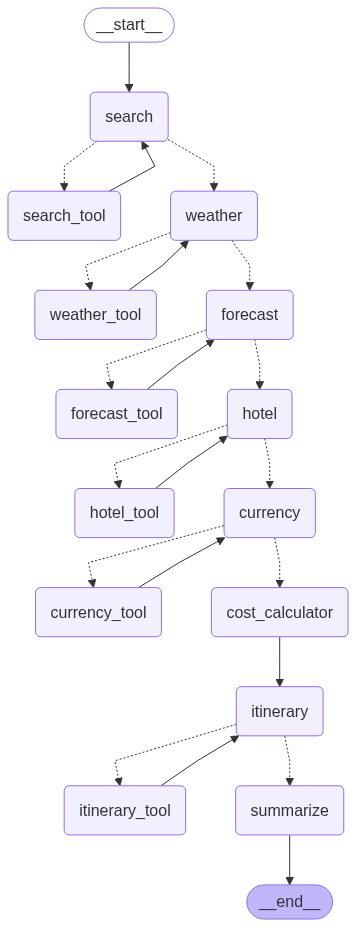

In [15]:
img_bytes = graph.get_graph().draw_mermaid_png()
with open('workflow.png', 'wb') as f:
    f.write(img_bytes)
display(Image(img_bytes))

In [16]:
state = {
    'messages': [
        HumanMessage('Create a plan for the given information')
    ],
    'metadata': {
        'city': 'Bali',
        'check_in': '1st July 2025',
        'check_out': '3rd July 2025',
        'adults': 1,
        'currency': 'INR',
        'budget': 10000
    }
}

In [17]:
response = graph.invoke(input=state)

In [18]:
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

Create a plan for the given information
================================== Ai Message ==================================

Bali offers a mix of cultural attractions and natural scenery, with must-visit spots like Tanah Lot temple, Ubud's art scene and rice terraces, and the beaches of Kuta and Seminyak. The island also features hidden waterfalls and traditional villages that showcase Balinese heritage. For dining, visitors can enjoy authentic Balinese and Indonesian dishes in local warungs as well as international cuisine in more upscale restaurants. This blend of attractions, scenic views, and diverse culinary options makes Bali a vibrant destination to explore.
================================== Ai Message ==================================
Tool Calls:
  WeatherTool (call_Py7fCjxm42rkzgoPSQZz8bSt)
 Call ID: call_Py7fCjxm42rkzgoPSQZz8bSt
  Args:
    city: Bali
================================= Tool Messag

In [20]:
doc = Document()
doc.add_heading('LangGraph Multi Tool Agent', level=1)
doc.add_paragraph(f'Create an itinerary for {response['metadata']['city']} from {response['metadata']['check_in']} to {response['metadata']['check_out']}')
doc.add_paragraph(response['summary_result'].content)
doc.save('itinerary_summary.docx')